In [1]:
# Importing and preparing our .CSV

import pandas as pd

source = "/kaggle/input/titanic/train.csv"
train_data = pd.read_csv(source)

# Test 
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

In [2]:
train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [3]:
# Analyzing & Stripping our features - Prepare Labels

X_train = train_data.drop(columns=['Survived','PassengerId', 'Cabin', 'Name','Ticket'])
y = train_data["Survived"]

# Test
X_testdata = test_data.drop(columns=['PassengerId', 'Cabin', 'Name','Ticket'])

In [4]:
# Binary Conversion - Visual 

X_train['Sex'] = X_train['Sex'].replace('male', '0')
X_train['Sex'] = X_train['Sex'].replace('female', '1')
X_train

# Test
X_testdata['Sex'] = X_testdata['Sex'].replace('male', '0')
X_testdata['Sex'] = X_testdata['Sex'].replace('female', '1')

In [5]:
# Displaying what column have NaN values to clean up

for col in X_train:
    if X_train[col].isnull().any().any():
        print(col)

# Test
for col in X_testdata:
    if X_testdata[col].isnull().any().any():
        print(col)

Age
Embarked
Age
Fare


In [6]:
# Transforming Data: Replace NaN through Imputation - Convert Categorical to OneHotEncoding

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [7]:
age_imputer = SimpleImputer(strategy='median')  
embarked_imputer = SimpleImputer(strategy='most_frequent')  

one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

# Test
fare_imputer = SimpleImputer(strategy='median')  

In [8]:
# Apply Transformations with our Tools 

preprocessor = ColumnTransformer(
    transformers=[
        ('age', age_imputer, ['Age']),
        ('fare', fare_imputer, ['Fare']),
        ('embarked', Pipeline(steps=[('impute', embarked_imputer),('encode', one_hot_encoder)]), ['Embarked'])
    ], remainder='passthrough')

X_transformed = preprocessor.fit_transform(X_train)

# Test
X_testdata_transformed = preprocessor.fit_transform(X_testdata)

In [9]:
# Correct Feature-Naming - Visualize clean Data 

correct_col_names = ['Age'] + ['Embarked_C', 'Embarked_Q', 'Embarked_S'] + ['Fare'] + [col for col in X_train.columns if col not in ['Age', 'Embarked', 'Fare']]

X_encoded = pd.DataFrame(X_transformed, columns=correct_col_names, index=X_train.index)
X_encoded.head()

# Test
X_testdata_encoded = pd.DataFrame(X_testdata_transformed, columns=correct_col_names, index=X_testdata.index)

In [10]:
# No NaN values remaining => No Output

for col in X_encoded:
    if X_encoded[col].isnull().any().any(): print(col)

In [11]:
# Splitting our Dataset for our ML Model

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [ ]:
# Exploring Hyperparam space using GridSearch

from sklearn.model_selection import GridSearchCV

model = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

y_pred = grid_search.best_estimator_.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy:.2f}")

In [12]:
# Creating Definitive ML Model with Best Params

model = RandomForestClassifier(bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=200, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

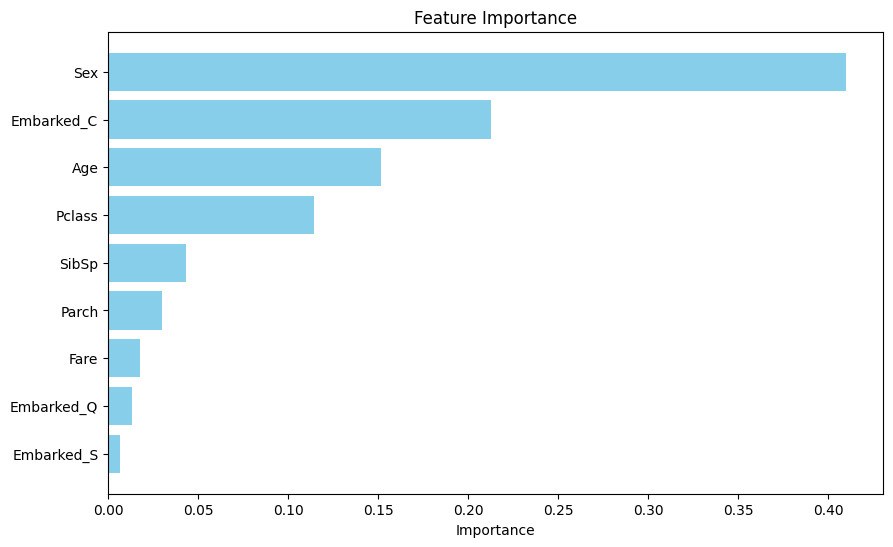

In [13]:
# Visualize our Results - Feature Importance (Sorted)

import matplotlib.pyplot as plt

feature_importances = pd.DataFrame({
    'feature': X_encoded.columns,  
    'importance': model.feature_importances_
})
feature_importances = feature_importances.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()


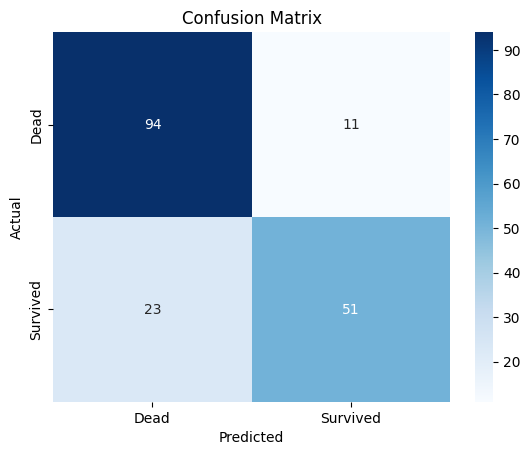

In [14]:
# Visualize Predictions - True Negatives (95) - False Positives (10) - False Negatives (23) - True Positives (51)

from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Dead', 'Survived'], yticklabels=['Dead', 'Survived'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


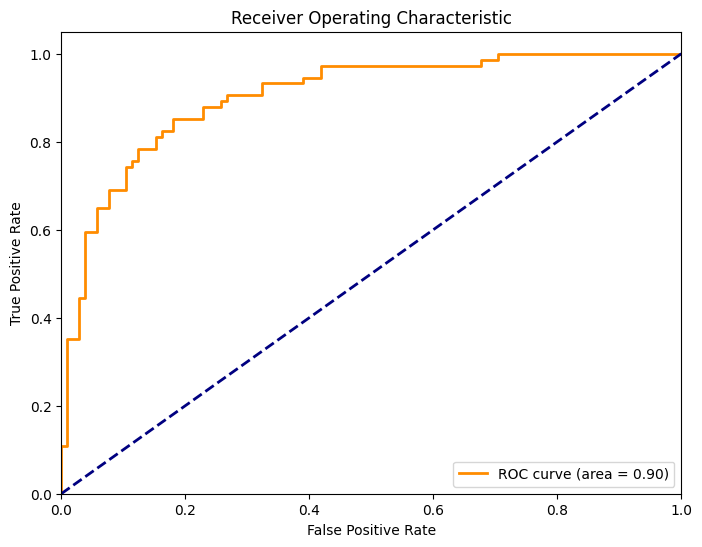

In [15]:
# Display ROC Curve

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

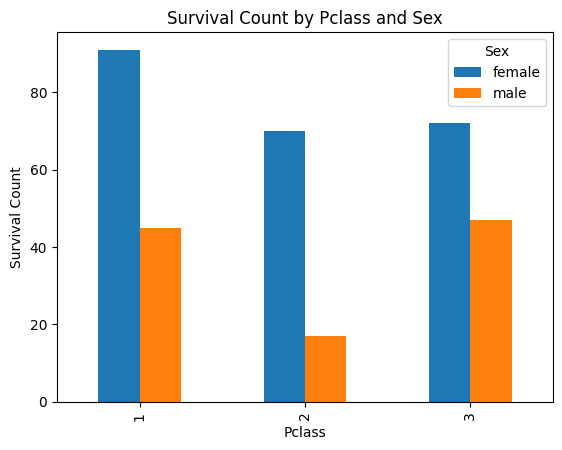

In [16]:
# Visualize survival counts by Pclass and Sex

survival_pclass_sex = train_data.groupby(['Pclass', 'Sex'])['Survived'].sum().unstack()
survival_pclass_sex.plot(kind='bar', stacked=False)
plt.title('Survival Count by Pclass and Sex')
plt.ylabel('Survival Count')
plt.show()

In [17]:
# Creating Definitive ML Model with Best Params for Submission

final_model = RandomForestClassifier(bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=200, random_state=42)

final_model.fit(X_encoded, y)

final_y_pred = model.predict(X_testdata_encoded)

In [18]:
# Inspect Classification Output 
final_y_pred

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [19]:
# Sort & Save Output
final_df = pd.DataFrame(test_data['PassengerId'])
final_df['Survived'] = final_y_pred
final_df.to_csv("predictions.csv", index=False)

In [20]:
# Inspect Submission
final_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
